# Часть 2 

---

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

pd.options.mode.chained_assignment = None 
pd.options.display.max_columns = 100
%matplotlib inline

## 2.1 Формирование дополнительных атрибутов

Получил данные из csv файла

In [2]:
df = pd.read_csv('input.csv')

In [3]:
df.head()

,properties.id,properties.light,properties.point.lat,properties.point.long,properties.region,properties.scheme,properties.address,properties.category,properties.datetime,properties.severity,properties.dead_count,properties.injured_count,properties.parent_region,properties.participants_count,year,brand,color,model,category,role_driver,gender_driver,health_status_driver,years_of_driving_experience,role_ped,gender_ped,health_status_ped,Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта),Остановка общественного транспорта,Регулируемый перекрёсток,Регулируемый пешеходный переход,Многоквартирные жилые дома,Административные здания,Нерегулируемый пешеходный переход,Автостоянка (отделенная от проезжей части),АЗС,Нерегулируемый перекрёсток,"Объект торговли, общественного питания на автодороге вне НП","Одиночный торговый объект, являющийся местом притяжения транспорта и (или) пешеходов",Внутридворовая территория,Выезд с прилегающей территории,Нерегулируемый перекрёсток неравнозначных улиц (дорог),Жилые дома индивидуальной застройки,Остановка трамвая,Школа либо иная детская (в т.ч. дошкольная) организация,Зоны отдыха,Регулируемый перекресток,"Мост, эстакада, путепровод",Объект строительства,Нерегулируемый перекрёсток равнозначных улиц (дорог),Мост,...,Отсутствие дорожных ограждений в необходимых местах,Отсутствие направляющих устройств и световозвращающих элементов на них,Отсутствие временных ТСОД в местах проведения работ,"Отсутствие, плохая различимость вертикальной разметки",Неисправность светофора,Несоответствие дорожных ограждений предъявляемым требованиям,Свежеуложенная поверхностная обработка,Загрязненное,Недостаточное освещение,Неровное покрытие,Нарушения в размещении наружной рекламы,"Сужение проезжей части, наличие препятствий, затрудняющих движение транспортных средств",Пыльное,Залитое (покрытое) водой,Несоответствие люков смотровых колодцев и ливневой канализации предъявляемым требованиям,Не установлено,Несоответствие железнодорожного переезда предъявляемым требованиям,"Плохая видимость световозвращателей, размещенных на дорожных ограждениях",Неудовлетворительное состояние разделительной полосы,Низкие сцепные качества покрытия,"Отклонение верха головки рельса трамвайных (железнодорожных) путей, расположенных в пределах проезжей части, относительно покрытия, более чем на 2,0 см",Все участники,Пешеходы,Общ. транспорт,Дети,Велосипедисты,Мотоциклисты,Движение вдоль проезжей части попутного направления вне населенного пункта при удовлетворительном состоянии обочины,Отсутствие световозвращающих элементов_ped,Иные нарушения_ped,Пешеход в состоянии алкогольного опьянения_ped,Переход через проезжую часть в неустановленном месте (при наличии в зоне видимости перекрёстка)_ped,Переход через проезжую часть вне пешеходного перехода в зоне его видимости либо при наличии в непосредственной близости подземного (надземного) пешеходного перехода_ped,Неподчинение сигналам регулирования_ped,Движение вдоль проезжей части при наличии и удовлетворительном состоянии тротуара_ped,Нахождение на проезжей части без цели её перехода_ped,Неожиданный выход из-за стоящего ТС_ped,Неожиданный выход из-за ТС,Игра на проезжей части,Неожиданный выход из-за сооружений (деревьев)_ped,Переход проезжей части перед приближающимся ТС с включёнными проблесковым маячком синего (сине-красного) цвета и звуковым сигналом_ped,Пешеход в возрасте до 7 лет без взрослого,Передвижение по проезжей части на скейтборде (роликовых коньках и т.д.)_ped,"Ожидание маршрутного ТС на проезжей части, вне посадочных площадок, тротуаров и обочин (при их наличии)",Переход проезжей части в запрещённом месте (оборудованном пешеходными ограждениями),Ходьба вдоль проезжей части попутного направления вне населенного пункта при удовлетворительном состоянии обочины,Ходьба вдоль проезжей части при наличии и удовлетворительном состоянии тротуара,Пешеход в состоянии наркотического опьянения,Оставление движущегося транспортного средства (выход или выпрыгивание на

Удалил строчки в которых нет адресса, тк как в последствии не получится вычислить опасные участки без этого параметра.

In [4]:
df = df[~df['properties.address'].str.contains("не указано")]
df = df.drop(index=[1687])
df.reset_index(drop=True, inplace=True)

Получение количетсва происшествий на 1 адрес

In [5]:
result = pd.merge(df, df.groupby(['properties.address']).size().sort_values(ascending=False).to_frame(), on="properties.address")
result.rename(columns={0: 'count'},inplace=True)
#result.groupby(['properties.address']).size().sort_values(ascending=False).to_frame()
df = result

In [6]:
df['Hazard_level'] = None

Вычисление индекса опасности

In [7]:
count_places_max = df['count'].max()
injured_max = df['properties.injured_count'].max()
dead_max = df['properties.dead_count'].max()

In [8]:
%%time
for i in range(len(df)):
    if df['properties.dead_count'][i] > 0:
        df['Hazard_level'][i] = (df['properties.injured_count'][i]+df['count'][i])/((injured_max+count_places_max)/2)/4
    else:
        df['Hazard_level'][i] = (df['properties.dead_count'][i]*100/dead_max)/100/2+0.5

CPU times: total: 1min 21s
Wall time: 1min 21s


In [9]:
df['Hazard_level'].describe()

count     708183.0
unique        70.0
top            0.5
freq      641177.0
Name: Hazard_level, dtype: float64

## 2.2 Кластеризация набора данных

Подобрал атрибуты которые оказывают наибольшее влияние на целевую переменную

In [10]:
X = df[['Hazard_level', 'properties.injured_count', 'properties.dead_count', 'properties.participants_count']]

Масштабирую выборку при помощи MinMaxScaler, что бы алгоритмы кластеризации быстрее работали

In [11]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Использовал анализ главных компонентов для уменьшения размера выборки

In [12]:
pca = PCA(n_components=2)
X = pca.fit_transform(X)

Функция для визуализации

In [13]:
def metrik(prediction):
    plt.figure(figsize=(12, 12))
    
    plt.subplot(224)
    plt.scatter(X[:, 0], X[:, 1], c=prediction)
    plt.title("Unevenly Sized Blobs")
    
    plt.show()

### Анализ индекса

In [14]:
X2 = df[['Hazard_level']]

In [15]:
scaler = MinMaxScaler()
X2 = scaler.fit_transform(X2)

In [16]:
pca = PCA(n_components=1, svd_solver='full')
X2 = pca.fit_transform(X2)

In [17]:
%%time
from sklearn.cluster import KMeans
model2 = KMeans(n_clusters=3)
model_fit2 = model2.fit(X2)
preds2 = model2.predict(X2)

CPU times: total: 17.3 s
Wall time: 1.61 s


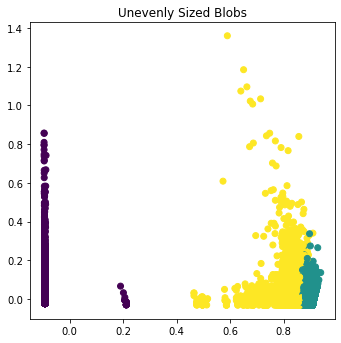

In [18]:
metrik(preds2)

In [19]:
davies_bouldin_score(X2, preds2)

0.3921719029099022

In [20]:
metrics.calinski_harabasz_score(X2, preds2)

899350381.0229894

###  Рассмотрел несколько алгоритмов для кластеризации

Я выбрал KMeans, MiniBatchKMeans и Birch так как это одни из самых популярных алгоритмов кластеризации

1 решил попробовать kmeans

In [21]:
%%time
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)
model_fit = model.fit(X)
preds = model.predict(X)

CPU times: total: 17 s
Wall time: 1.36 s


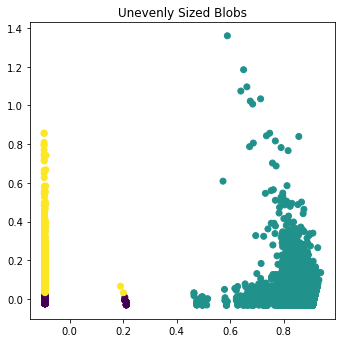

In [22]:
metrik(preds)

Теперь решил сравнить его с MiniBatchKMeans

In [23]:
%%time
from sklearn.cluster import MiniBatchKMeans
mimikmeans = MiniBatchKMeans(n_clusters=3,batch_size=4096)
miniBatch = mimikmeans.fit_predict(X)

CPU times: total: 797 ms
Wall time: 88 ms


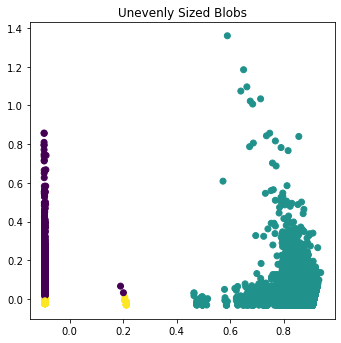

In [24]:
metrik(miniBatch)

И на последок Birch

In [25]:
%%time
from sklearn.cluster import Birch
brc = Birch(n_clusters=3)
brc.fit(X)
birtch = brc.predict(X)

CPU times: total: 6.88 s
Wall time: 6.54 s


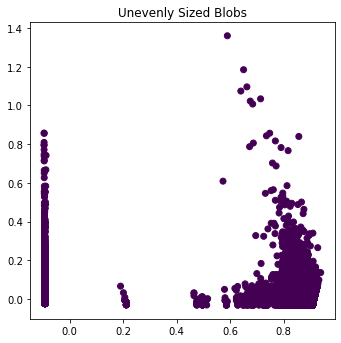

In [26]:
metrik(birtch)

### Оценка качества кластеризации

Выбрал метрики davies_bouldin_score и calinski_harabasz_score, потому что наглядно и быстро могут оценить работу алгоритмов кластеризации

Kmeans

In [27]:
davies_bouldin_score(X, preds)

0.36745541120398933

In [28]:
metrics.calinski_harabasz_score(X, preds)

72699714.99806313

MiniBatchKMeans

In [29]:
davies_bouldin_score(X, miniBatch)

0.39151313315733693

In [30]:
metrics.calinski_harabasz_score(X, miniBatch)

72508696.98364091

Birch

Birch не поддается оценке качества, так как он нашел только 1 клсатер

### По рузультатам метрик KMeans показал более хороший результат, так что выбиру его

In [31]:
df['KMeans'] = preds

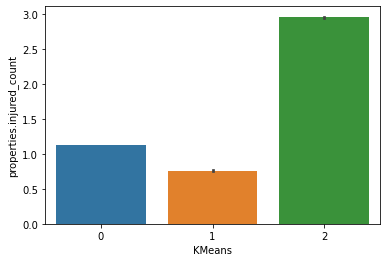

In [32]:
sns.barplot(x=df['KMeans'], y=df['properties.injured_count']);

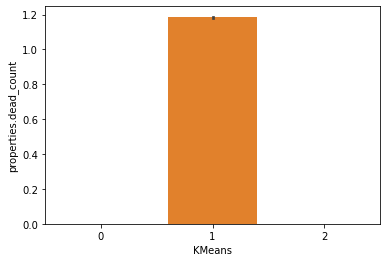

In [33]:
sns.barplot(x=df['KMeans'], y=df['properties.dead_count']);

Первый график показывает, что количество пострадавших во 2м кластере очень большое, особенно по отношению к первому кластеру, но это из за того что в 1м кластере много погибших (это уже видно по второму графику). В кластере под номером 0 нет погибших и мало пострадавших, по-этому можно сделать вывод:<br>
0 - Мало пострадавших, не очень опасно<br>
1 - Самый опасный<br>
2 - Много пострадавших<br>

In [34]:
df['KMeans'] = df['KMeans'].replace(0, 'Вмешательство не требуется')
df['KMeans'] = df['KMeans'].replace(1, 'Требует немедленного вмешательства')
df['KMeans'] = df['KMeans'].replace(2, 'Требует вмешательства')

## 2.3 Разбиение набора данных

Решил оставить главными метки от алгоритма kmeans, так как в большинстве случаев он показывает себя самым надежным и является довольно быстрым.

Буду разделять данные на выборки используя train_test_split, так как с его помощью можно раскидать по выборкам данные со всех регионов

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df, df['KMeans'], test_size=0.33, random_state=42, stratify=df['properties.parent_region'])

## 2.4 Подготовка отчета

В ходе работы было проделано:
* 2.1 Формирование дополнительных атрибутов - Был сформирован индекс опасности;
* 2.2 Кластеризация набора данных -Было рассмотрено 3 алгоритма класстьеризации; была произведена кластеризация 3мя методами (KMeans, MiniBatchKMeans и Birch); Был проведен анализ качества кластеризации; была сделана визуализация разделения на кластеры; был выбран 1 из 3х алгоритмов кластеризации (KMeans);
* 2.3 Разбиение набора данных - набор данных был разделен на обучающую и тестовую выборку;

In [36]:
df.to_csv('output.csv')